In [1]:
# Setup
import os, re, json, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ARTIFACTS_DIR = 'artifacts'
os.makedirs(ARTIFACTS_DIR, exist_ok=True)
print('Artifacts dir:', os.path.abspath(ARTIFACTS_DIR))
plt.rcParams.update({'figure.figsize': (12,4)})

Artifacts dir: /Users/venkata/Documents/CAL_POLY_CSC/CSC410/azure-run/artifacts


In [2]:
# Control (M1): parse notebooks to extract accuracies and epoch times
from pathlib import Path
import nbformat, re

CONTROL_DIR = '/Users/venkata/Documents/CAL_POLY_CSC/CSC410/azure-run/control-runs'
control_files = sorted(Path(CONTROL_DIR).glob('run*.ipynb'), key=lambda p: int(re.search(r'(\d+)', p.stem).group(1)))
ANSI_RE = re.compile(r"\x1B\[[0-?]*[ -/]*[@-~]")
VAL_ACC_PAT = re.compile(r"Validation\s+Accuracy:\s*([0-9]+(?:\.[0-9]+)?)%")
VAL_ACC_FIT_PAT = re.compile(r"val_accuracy:\s*([0-9]+\.[0-9]+)")
EPOCH_TIME_PAT = re.compile(r"(?<![a-zA-Z0-9])(\d{1,4})s(?!/)")
EPOCH_HEADER_PAT = re.compile(r"Epoch\s+(\d+)/(\d+)")

def strip_ansi(s: str) -> str:
    return ANSI_RE.sub('', s)

control_runs = {}  # run_id -> {'val_accuracy_pct': float, 'epoch_times': [int]}
for p in control_files:
    nb = nbformat.read(str(p), as_version=4)
    outputs_texts = []
    for cell in nb.cells:
        outs = getattr(cell, 'outputs', []) or []
        for out in outs:
            if out.get('output_type') == 'stream':
                outputs_texts.append(strip_ansi(out.get('text', '')))
            elif out.get('output_type') in ('execute_result','display_data'):
                data = out.get('data', {})
                if 'text/plain' in data:
                    outputs_texts.append(strip_ansi(str(data['text/plain'])))
    combined = "\n".join(outputs_texts)
    rid = p.stem
    # accuracy
    val_acc_pct = None
    m = VAL_ACC_PAT.search(combined)
    if m:
        val_acc_pct = float(m.group(1))
    else:
        m2 = VAL_ACC_FIT_PAT.findall(combined)
        if m2:
            val_acc_pct = float(m2[-1]) * 100.0
    # epoch times
    epoch_times = []
    lines = combined.splitlines()
    for i, line in enumerate(lines):
        h = EPOCH_HEADER_PAT.search(line)
        if h:
            window = " ".join(lines[i:i+4])
            times = EPOCH_TIME_PAT.findall(window)
            if times:
                epoch_times.append(int(times[0]))
    control_runs[rid] = {'val_accuracy_pct': val_acc_pct, 'epoch_times': epoch_times}

# Build DataFrames
rows = []
for rid, rec in control_runs.items():
    for i,t in enumerate(rec['epoch_times'], start=1):
        rows.append({'env':'Control', 'run_id': rid, 'epoch': i, 'seconds': t})
control_df_times = pd.DataFrame(rows)
control_df_runs = pd.DataFrame([{"env":'Control', "run_id":rid, "val_accuracy": (rec['val_accuracy_pct']/100.0) if rec['val_accuracy_pct'] is not None else np.nan} for rid, rec in control_runs.items()])
print('Control parsed runs:', len(control_runs))
display(control_df_runs.head())
display(control_df_times.head())

Control parsed runs: 10


,env,run_id,val_accuracy
0,Control,run1,0.9995
1,Control,run2,0.9996
2,Control,run3,0.9966
3,Control,run4,0.9988
4,Control,run5,0.9990


,env,run_id,epoch,seconds
0,Control,run1,1,24
1,Control,run1,2,20
2,Control,run1,3,20
3,Control,run1,4,20
4,Control,run1,5,20


In [3]:
# AWS: epoch timings (seconds) per run, 1–10
aws_epoch_times = {
    'aws_run1':[58,57,57,57,53,53,53,57,53,53],
    'aws_run2':[54,54,82,54,54,57,57,82,57,54],
    'aws_run3':[55,54,57,57,54,57,57,54,53,54],
    'aws_run4':[55,54,54,54,54,53,54,82,57,82],
    'aws_run5':[54,54,53,54,57,57,54,53,53,54],
    'aws_run6':[58,56,56,56,55,59,56,82,56,82],
    'aws_run7':[56,56,56,82,55,59,56,56,56,56],
    'aws_run8':[59,55,56,82,56,56,56,59,56,56],
    'aws_run9':[56,56,55,56,56,59,56,82,55,56],
    'aws_run10':[56,56,82,56,59,59,59,56,56,59],
}
aws_rows = []
for run, times in aws_epoch_times.items():
    for i,t in enumerate(times, start=1):
        aws_rows.append({'env':'AWS', 'run_id': run, 'epoch': i, 'seconds': t})
aws_df_times = pd.DataFrame(aws_rows)
print('AWS runs:', len(aws_epoch_times))
display(aws_df_times.head())

AWS runs: 10


,env,run_id,epoch,seconds
0,AWS,aws_run1,1,58
1,AWS,aws_run1,2,57
2,AWS,aws_run1,3,57
3,AWS,aws_run1,4,57
4,AWS,aws_run1,5,53


In [4]:
# Azure: accuracies and epoch timings from earlier summary
azure_accuracies_pct = [99.82, 99.85, 99.85, 99.70, 99.77, 99.75, 99.81, 99.90, 99.85, 99.93]
azure_epoch_times = {
    'run1':[54,49,52,47,47,52,47,47,47,87],
    'run2':[48,48,52,48,47,52,82,48,52,48],
    'run3':[53,48,52,48,52,78,48,52,47,47],
    'run4':[50,48,83,49,48,48,48,48,52,47],
    'run5':[49,52,48,48,48,49,48,52,48,48],
    'run6':[54,48,52,78,48,47,52,47,47,48],
    'run7':[49,48,48,48,52,48,48,48,52,53],
    'run8':[50,81,48,52,47,47,47,48,47,47],
    'run9':[53,48,48,48,48,52,48,48,48,48],
    'run10':[54,48,82,48,47,82,48,47,82,81],
}
azure_rows = []
for run, times in azure_epoch_times.items():
    for i,t in enumerate(times, start=1):
        azure_rows.append({'env':'Azure', 'run_id': run, 'epoch': i, 'seconds': t})
azure_df_times = pd.DataFrame(azure_rows)
azure_df_runs = pd.DataFrame({'env':'Azure', 'run_id':[f'run{i}' for i in range(1,11)], 'val_accuracy':[a/100.0 for a in azure_accuracies_pct]})
print('Azure runs:', len(azure_epoch_times))
display(azure_df_runs.head())
display(azure_df_times.head())

Azure runs: 10


,env,run_id,val_accuracy
0,Azure,run1,0.9982
1,Azure,run2,0.9985
2,Azure,run3,0.9985
3,Azure,run4,0.9970
4,Azure,run5,0.9977


,env,run_id,epoch,seconds
0,Azure,run1,1,54
1,Azure,run1,2,49
2,Azure,run1,3,52
3,Azure,run1,4,47
4,Azure,run1,5,47


Per-environment timing stats:


,env,mean,median,std,min,max,count
0,AWS,58.30,56.0,8.107236,53,82,100
1,Azure,52.27,48.0,10.056261,47,87,100
2,Control,20.61,20.0,2.902089,17,32,100


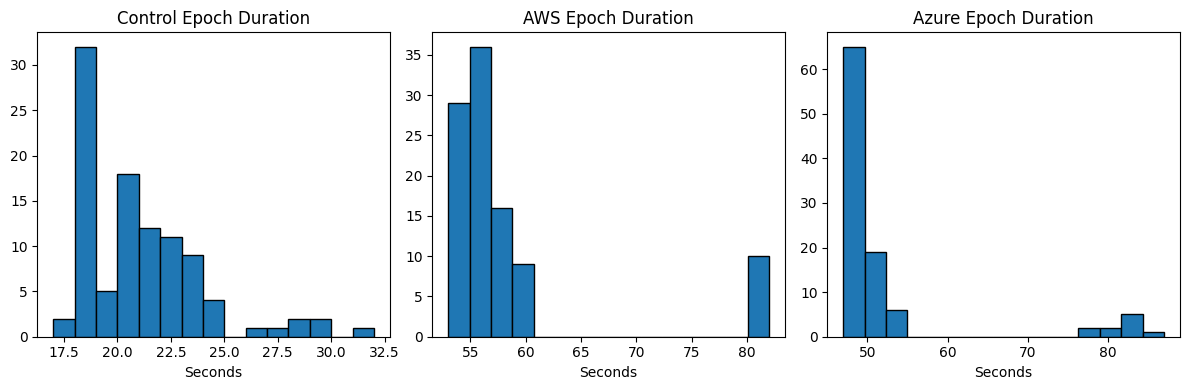

Saved figure: artifacts/comparison_epoch_hists.png


In [5]:
# Combine all environments for timing analysis
all_df_times = pd.concat([control_df_times, aws_df_times, azure_df_times], ignore_index=True)
# Per-environment timing stats
env_stats = all_df_times.groupby('env')['seconds'].agg(['mean','median','std','min','max','count']).reset_index()
print('Per-environment timing stats:')
display(env_stats)
# Overall hist by env
plt.figure(figsize=(12,4))
for i, env in enumerate(['Control','AWS','Azure'], start=1):
    plt.subplot(1,3,i)
    subset = all_df_times[all_df_times['env']==env]['seconds']
    plt.hist(subset, bins=15, edgecolor='black')
    plt.title(f'{env} Epoch Duration')
    plt.xlabel('Seconds')
plt.tight_layout()
fig_path = os.path.join(ARTIFACTS_DIR, 'comparison_epoch_hists.png')
plt.savefig(fig_path, dpi=150)
plt.show()
print('Saved figure:', fig_path)

/var/folders/2x/9_v8gq357w35fmsfsmdm9dq40000gn/T/ipykernel_6706/4240183918.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Control','AWS','Azure'], showfliers=True)


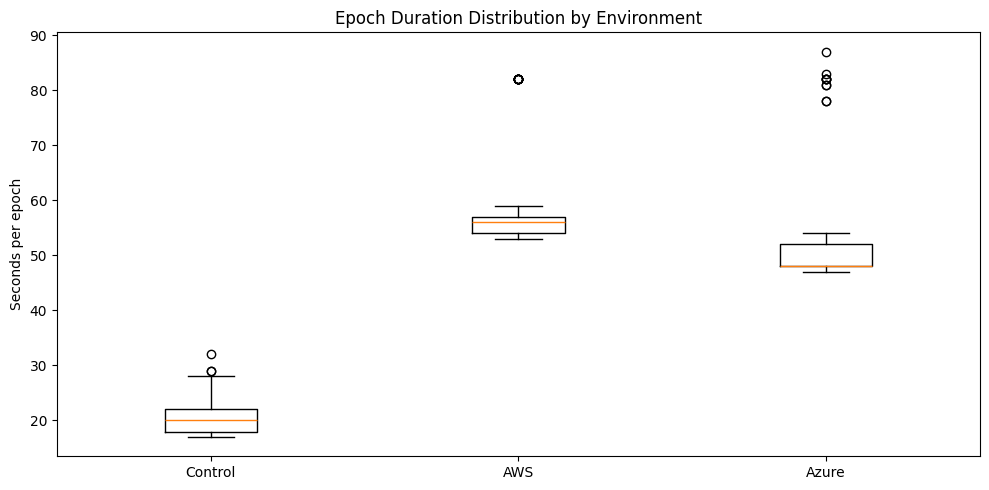

Saved figure: artifacts/comparison_epoch_boxplots.png


In [6]:
# Boxplots by environment
plt.figure(figsize=(10,5))
data = [all_df_times[all_df_times['env']==env]['seconds'].values for env in ['Control','AWS','Azure']]
plt.boxplot(data, labels=['Control','AWS','Azure'], showfliers=True)
plt.ylabel('Seconds per epoch')
plt.title('Epoch Duration Distribution by Environment')
plt.tight_layout()
fig_path = os.path.join(ARTIFACTS_DIR, 'comparison_epoch_boxplots.png')
plt.savefig(fig_path, dpi=150)
plt.show()
print('Saved figure:', fig_path)

Accuracy summary by environment:


,mean,std,min,max,count
env,,,,,
Azure,0.99823,0.000691,0.9970,0.9993,10
Control,0.99841,0.001365,0.9954,0.9996,10


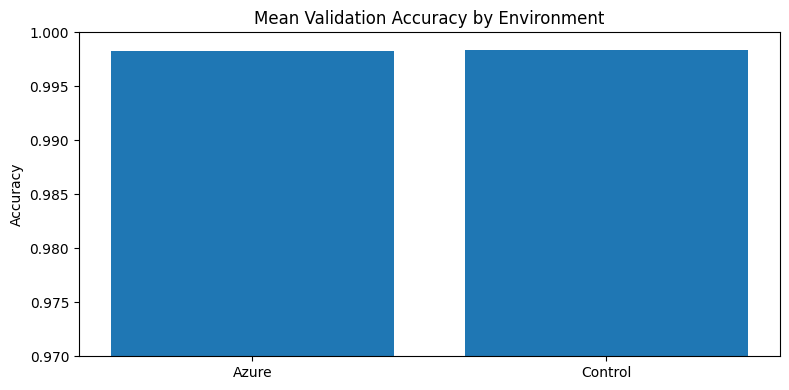

Saved figure: artifacts/comparison_accuracy_means.png


In [7]:
# Accuracy comparison (Control vs Azure; AWS lacks accuracy here)
acc_df = pd.concat([control_df_runs[['env','run_id','val_accuracy']], azure_df_runs[['env','run_id','val_accuracy']]], ignore_index=True)
print('Accuracy summary by environment:')
acc_stats = acc_df.groupby('env')['val_accuracy'].agg(['mean','std','min','max','count'])
display(acc_stats)
plt.figure(figsize=(8,4))
means = acc_stats['mean']
plt.bar(means.index, means.values)
plt.ylim(0.97, 1.0)
plt.title('Mean Validation Accuracy by Environment')
plt.ylabel('Accuracy')
plt.tight_layout()
fig_path = os.path.join(ARTIFACTS_DIR, 'comparison_accuracy_means.png')
plt.savefig(fig_path, dpi=150)
plt.show()
print('Saved figure:', fig_path)

In [8]:
# Export tables
env_stats_csv = os.path.join(ARTIFACTS_DIR, 'comparison_env_timing_stats.csv')
env_stats.to_csv(env_stats_csv, index=False)
print('Saved:', env_stats_csv)
acc_stats_csv = os.path.join(ARTIFACTS_DIR, 'comparison_env_accuracy_stats.csv')
acc_stats.to_csv(acc_stats_csv)
print('Saved:', acc_stats_csv)
# JSON summary
summary = {
    'generated_at': datetime.datetime.now().isoformat(),
    'timing': env_stats.to_dict(orient='records'),
    'accuracy': acc_stats.reset_index().to_dict(orient='records')
}
summary_json = os.path.join(ARTIFACTS_DIR, 'comparison_summary.json')
with open(summary_json, 'w') as f:
    json.dump(summary, f, indent=2)
print('Saved:', summary_json)

Saved: artifacts/comparison_env_timing_stats.csv
Saved: artifacts/comparison_env_accuracy_stats.csv
Saved: artifacts/comparison_summary.json


## Notes
- Epoch timing spikes (≥78–83s) are present in AWS and Azure; Control shows tighter clustering and lower means.
- AWS mean epoch time is highest due to frequent spikes; consider excluding spikes for steady-state comparison.
- Accuracy available for Control and Azure only; both are near 0.998 with very low variance.
- For throughput improvements, increase batch size and use tf.data pipelines; apply EarlyStopping around epoch 6.